# Adidas Ad Spend and Google Trends Analysis
By: Kevin Heenan, Krista Labovich, Sarah Holmes, and Christopher Cannon

# Load Dependencies and our Ad Spend Data

In [15]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as pyplot
from datetime import date
import seaborn as sns
from statsmodels.tsa import stattools
from statistics import mode
from google.colab import drive

In [71]:
drive.mount('/content/drive/')
dfa = pd.read_csv('drive/MyDrive/adidas.adspend.csv')
dfa.head(3)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),SUNDAY MAGS DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Adidas : Sneakers Men,580.4,0.0,580.4,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,"WEEK OF OCT 07, 2013 (B)",Adidas : Soccer Apparel & Shoes,74.7,0.0,74.7,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,"WEEK OF OCT 07, 2013 (B)",Adidas CrazyQuick : Sneakers Men,10.5,0.0,10.5,0.0,0.0,0,0.0,0.0,0,0.0,0.0


In [70]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


# Ad Spend Data Cleaning

Looks like we have a few things to take care of as far as data cleanup.  To name a few:


1.   TIME PERIOD is a string.  Convert to DateTime
2.   Product is not necessary.  We don't have Google Trends data at the Product level do we?  <-- No.
3.   Clean up extranneous string on column headers.
4.   Make sure our time periods line up with our Google Trends time periods.  They only differ by a day (Google Trends weeks are Sun-Sat, Adspend weeks are Mon-Sun).  But we will still clean that up before we try and join the two datasets.



In [73]:
dfa['TIME PERIOD'] = dfa['TIME PERIOD'].str.replace("WEEK OF ", "")
dfa['TIME PERIOD'] = dfa['TIME PERIOD'].str.replace("\(B\)", "")
dfa.columns = dfa.columns.str.replace(" DOLS \(000\)", "")
dfa['FIXED TIME'] = pd.to_datetime(dfa['TIME PERIOD'])
dfa.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,TIME PERIOD,PRODUCT,TOTAL,NETWORK TV,CABLE TV,SPOT TV,MAGAZINES,SUNDAY MAGS,NATL NEWSP,NEWSPAPER,NETWORK RADIO,NAT SPOT RADIO,OUTDOOR,FIXED TIME
0,"OCT 07, 2013",Adidas : Sneakers Men,580.4,0.0,580.4,0.0,0.0,0,0.0,0.0,0,0.0,0.0,2013-10-07
1,"OCT 07, 2013",Adidas : Soccer Apparel & Shoes,74.7,0.0,74.7,0.0,0.0,0,0.0,0.0,0,0.0,0.0,2013-10-07
2,"OCT 07, 2013",Adidas CrazyQuick : Sneakers Men,10.5,0.0,10.5,0.0,0.0,0,0.0,0.0,0,0.0,0.0,2013-10-07


In [74]:
list(dfa)

['TIME PERIOD',
 'PRODUCT',
 'TOTAL',
 'NETWORK TV',
 'CABLE TV',
 'SPOT TV',
 'MAGAZINES',
 'SUNDAY MAGS',
 'NATL NEWSP',
 'NEWSPAPER',
 'NETWORK RADIO',
 'NAT SPOT RADIO',
 'OUTDOOR',
 'FIXED TIME']

In [75]:
# Get rid of 'product' and find the total ad spend per week.
adspendnoproducts=dfa.pivot_table(index='FIXED TIME', aggfunc=np.sum) 
list(adspendnoproducts) # Products column is now gone

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK RADIO',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'SUNDAY MAGS',
 'TOTAL']

In [76]:
# And the number of rows is now reduced to 249 since we have one row per week
adspendnoproducts.index

DatetimeIndex(['2013-10-07', '2013-10-14', '2013-10-21', '2013-10-28',
               '2013-11-04', '2013-11-11', '2013-11-18', '2013-11-25',
               '2013-12-02', '2013-12-09',
               ...
               '2018-06-25', '2018-07-02', '2018-07-09', '2018-07-16',
               '2018-07-23', '2018-07-30', '2018-08-20', '2018-08-27',
               '2018-09-17', '2018-10-01'],
              dtype='datetime64[ns]', name='FIXED TIME', length=249, freq=None)

### Graphing Advertising Expenditures

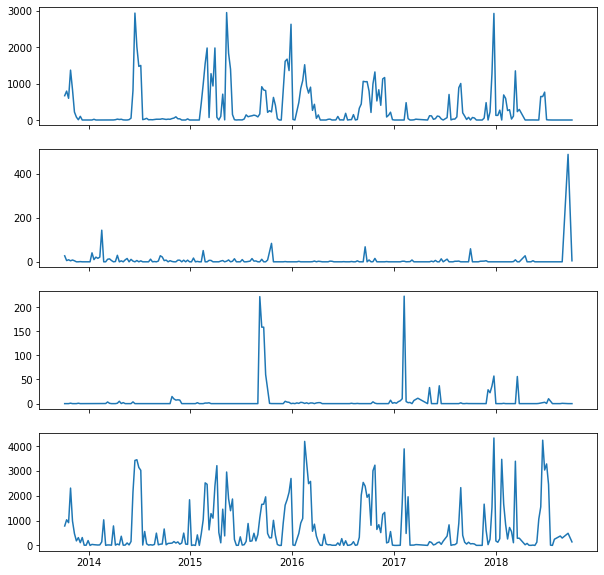

In [77]:
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex='all')

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'])
  # Newspaper got a spike recently, wonder why that is?
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV'])
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])


To recap, we have total weekly ad expenditures by magazines, newspapers, cable, etc. as well as the weekly sum.

But as we discussed earlier, there is an alignment problem with our current weekly Adspend data (which starts on Mondays) and the Google Trends data (which starts on Sundays).

When we load the Google Trends data we will align it with Adspend's weeks.

In [78]:
# But how do we know Adspend starts on Mondays?  With a simple test.  Here we test the first row's Time Period for its day of week.
testdate = pd.to_datetime("2013-10-07")
testdate.weekday()

0

0 is Monday. 

Reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.weekday.html

# Loading and Using Google Trends Data

In [79]:
df_gtrends = pd.read_csv('drive/MyDrive/GTrends_Weekly.csv', parse_dates=['Week'])
df_gtrends['Week'] = df_gtrends['Week'] + pd.Timedelta(1, unit='D') # Add a day to align with the adspend information.
df_gtrends.set_index('Week', inplace = True)
df_gtrends.index.names = ['period']
df_gtrends.head(3)

,ADIDAS: (United States)
period,
2013-10-07,17
2013-10-14,17
2013-10-21,17


# New Section

### Merge the data!

Now, we bring it all together by merging our adidasweekly data (from Google Trends) and our adspendnoproducts data (adspend data after we cleaned it and dropped product info).

In [80]:
mergedweeklydata = adspendnoproducts.join(df_gtrends)
mergedweeklydata.head(3)

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL,ADIDAS: (United States)
FIXED TIME,,,,,,,,,,,,
2013-10-07,665.6,0.0,10.1,77.9,0,0.0,27.2,0.0,0.0,0,780.8,17
2013-10-14,792.6,0.0,10.1,0.0,0,222.0,5.6,0.0,0.0,0,1030.3,17
2013-10-21,594.2,0.0,10.1,0.0,0,300.0,9.3,0.0,0.0,0,913.6,17


In [81]:
mergedweeklydata.tail(3)

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL,ADIDAS: (United States)
FIXED TIME,,,,,,,,,,,,
2018-08-27,0.0,0.0,0.0,0.0,0,0.0,0.0,295.3,0.6,0,295.9,52
2018-09-17,0.0,0.0,0.0,0.0,0,0.0,488.1,0.0,0.0,0,488.1,58
2018-10-01,0.0,0.0,3.6,0.0,0,0.0,4.7,133.6,0.0,0,141.9,48


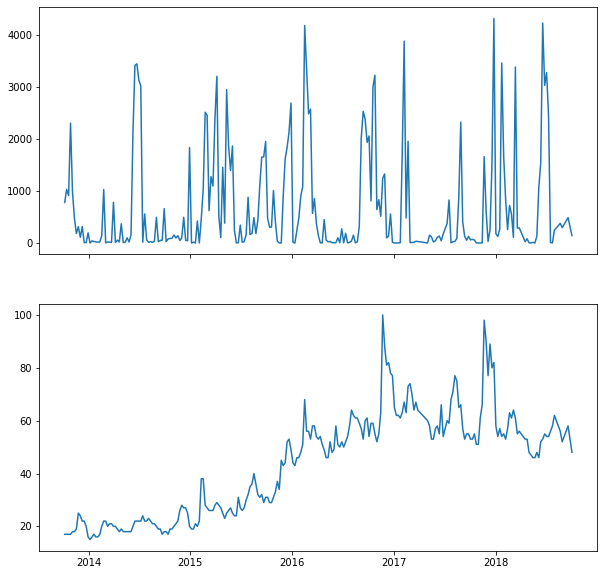

In [82]:
# Compare TOTAL Adspend (top) with the Google Trends data (bottom).
dimensions = (10, 10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex = 'all')

ax1.plot(mergedweeklydata.index, mergedweeklydata['TOTAL'])
ax2.plot(mergedweeklydata.index, mergedweeklydata['ADIDAS: (United States)'])

# Correlation analysis


## Basic Correlation Analysis

In [83]:
mergedweeklydata['TOTAL'].corr(mergedweeklydata['ADIDAS: (United States)'])

0.10550087802049914

Incorporate stationary data to do further modeling.

In [84]:
mergedweeklydata['TOTALdiff'] = mergedweeklydata['TOTAL'].diff(1)
mergedweeklydata['valuediff'] = mergedweeklydata['ADIDAS: (United States)'].diff(1)
#we can run a regression on these variables now, to understand if the adspend predicts the google search interests
mergedweeklydata.head(3)

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL,ADIDAS: (United States),TOTALdiff,valuediff
FIXED TIME,,,,,,,,,,,,,,
2013-10-07,665.6,0.0,10.1,77.9,0,0.0,27.2,0.0,0.0,0,780.8,17,NaN,NaN
2013-10-14,792.6,0.0,10.1,0.0,0,222.0,5.6,0.0,0.0,0,1030.3,17,249.5,0.0
2013-10-21,594.2,0.0,10.1,0.0,0,300.0,9.3,0.0,0.0,0,913.6,17,-116.7,0.0


In [85]:
mergedweeklydata['TOTALdiff'].corr(mergedweeklydata['valuediff'])

0.231222035424008

## Correlation Heatmap

The correlation improved substantially after differencing, suggesting we might be able to find a relationship in the data after all.  Lets continue to pursue this correlation analysis.

In [86]:
adspend_trends = mergedweeklydata.drop(columns=['TOTALdiff', 'valuediff'])

correlationlist = []
for acolumn in list(adspend_trends):
    if "ADIDAS: (United States)" not in acolumn:
        corr = adspend_trends[acolumn].corr(adspend_trends['ADIDAS: (United States)'])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV 0.046183171337562536
MAGAZINES -0.2567580069746047
NAT SPOT RADIO -0.3118583575601364
NATL NEWSP 0.05637075231901379
NETWORK RADIO nan
NETWORK TV 0.19321986224976967
NEWSPAPER -0.03254587205346802
OUTDOOR -0.05256741341866055
SPOT TV 0.04288178016339944
SUNDAY MAGS nan
TOTAL 0.10550087802049914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


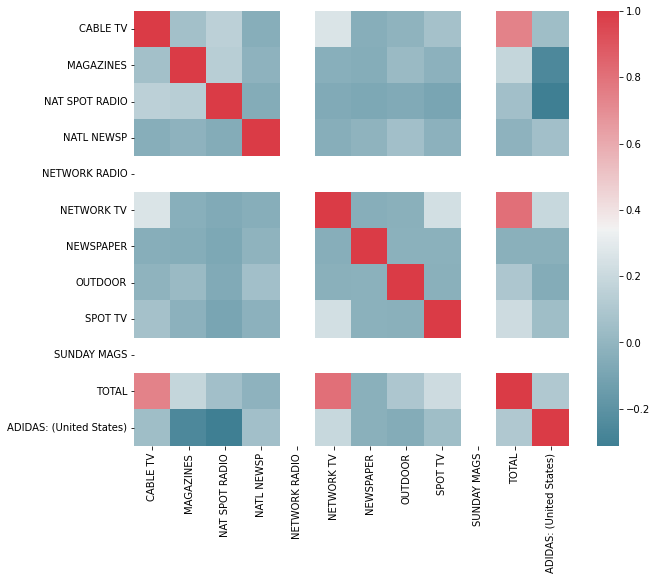

In [87]:
# That list of features is tough to read, lets view it as a plot
f, ax = pyplot.subplots(figsize=(10,8))
corr = adspend_trends.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap= True),
            square = True, ax=ax)

It looks like TOTAL spending and CABLE TV spending are correlated, same with TOTAL spending and NETWORK TV spending.  But neither CABLE TV or NETWORK TV appear correlated with the target variable (reminder: it is *Adidas: (United States)*).  

As it stands, the most highly correlated with the target is NETWORK TV.

# Consult with the High (FB) Prophet

https://halo.fandom.com/wiki/Hierarchs

## Setup

In [88]:
prophetdata = df_gtrends.copy(deep=True)
prophetdata.reset_index(level=0, inplace = True)
# prophetdata.rename(str.lower, axis='columns')
prophetdata = prophetdata.rename(columns={"period": "ds", "ADIDAS: (United States)": "y"})
prophetdata.head(3)

,ds,y
0,2013-10-07,17
1,2013-10-14,17
2,2013-10-21,17


## Original

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


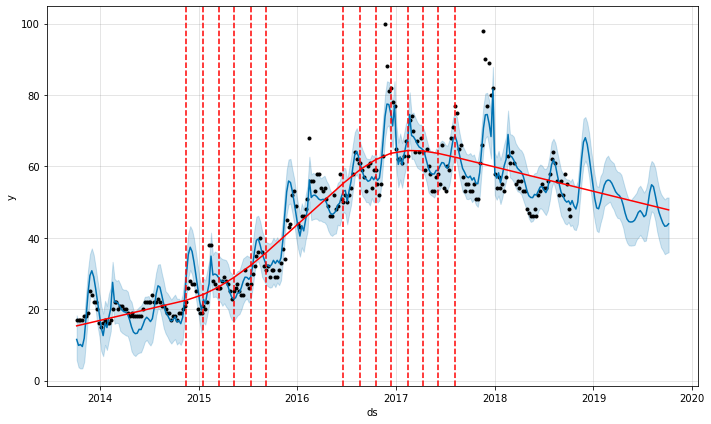

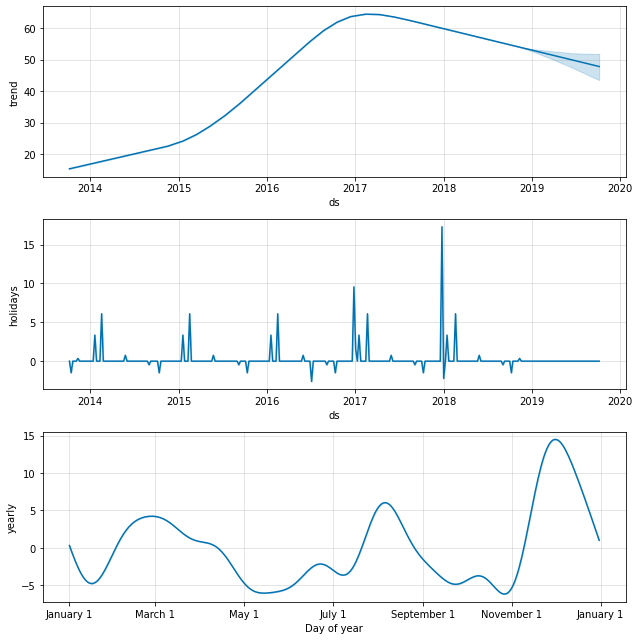

In [89]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(prophetdata)

future = m.make_future_dataframe(periods=52, freq='W')
# future.tail()

future = m.predict(future)
fig1 = m.plot(future)
fig2 = m.plot_components(future)
a = add_changepoints_to_plot(fig1.gca(), m, future)

## Manually Set Changepoints

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


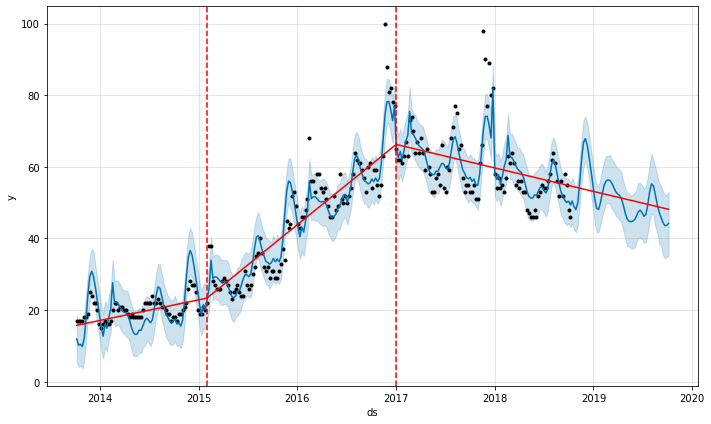

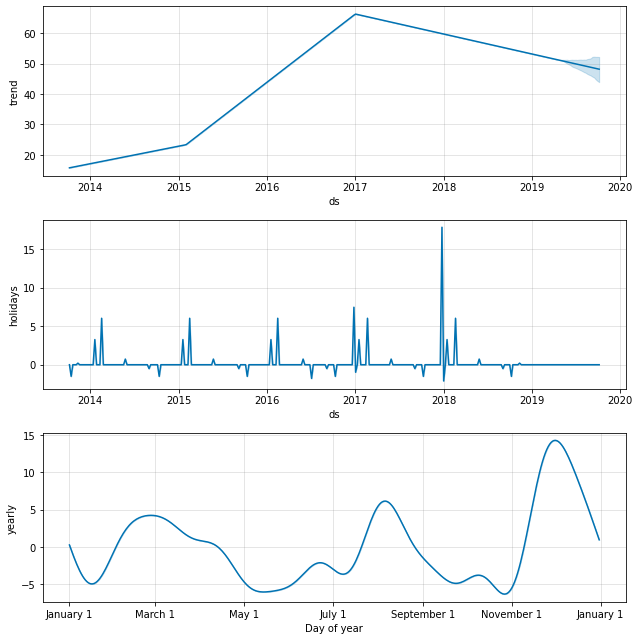

In [90]:
changepoints = ['2015-02-01', '2017-01-01']
m = Prophet(changepoints=changepoints)
m.add_country_holidays(country_name='US')
m.fit(prophetdata)
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

## Add the Adspend Data

For now this is broken.  We need to "know" future adspend and put that into the future df for this to work.  How do we learn what future adspend will be?

In [91]:
# Re-pull Google Trends data and format it for FB Prophet
prophetdata2 = df_gtrends.copy(deep=True)
prophetdata2.reset_index(level=0, inplace = True)
# prophetdata.rename(str.lower, axis='columns')
prophetdata2 = prophetdata.rename(columns={"period": "ds", "ADIDAS: (United States)": "y"})
prophetdata2.head(3)

,ds,y
0,2013-10-07,17
1,2013-10-14,17
2,2013-10-21,17


In [92]:
# Pull Adspend data as a function of time to prepare it for FB Prophet
adprophet = mergedweeklydata.copy(deep=True)
adprophet.reset_index(level=0, inplace = True)
adprophet = adprophet.rename(columns={"FIXED TIME": "ds", "TOTAL": "y"})
adprophet.drop(['CABLE TV', 'MAGAZINES', 'NAT SPOT RADIO', 'ADIDAS: (United States)',
                   'NATL NEWSP', 'NETWORK RADIO', 'NETWORK TV',
                   'NEWSPAPER', 'OUTDOOR', 'SPOT TV', 'SUNDAY MAGS'], axis=1, inplace=True)
adprophet

,ds,y,TOTALdiff,valuediff
0,2013-10-07,780.8,NaN,NaN
1,2013-10-14,1030.3,249.5,0.0
2,2013-10-21,913.6,-116.7,0.0
3,2013-10-28,2304.2,1390.6,0.0
4,2013-11-04,982.8,-1321.4,1.0
...,...,...,...,...
244,2018-07-30,248.2,245.7,4.0
245,2018-08-20,378.5,130.3,-6.0
246,2018-08-27,295.9,-82.6,-4.0
247,2018-09-17,488.1,192.2,6.0


In [93]:
# Run our Adspend data through FB Prophet to generate a forecast for how ADIDAS will spend money on ads
changepoints = ['2015-02-01', '2017-01-01']
m = Prophet(changepoints=changepoints)
m.add_country_holidays(country_name='US')
m.fit(adprophet)
future = m.make_future_dataframe(periods=65, freq='W')
forecast = m.predict(future)
# fig1 = m.plot(forecast)
# fig2 = m.plot_components(forecast)
# a = add_changepoints_to_plot(fig1.gca(), m, forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [94]:
# Pull out the future Adspend values and add it to the new prophetdata2 object we created for this section
future_adspend = pd.DataFrame(forecast['yhat'])
future_adspend.reset_index(0, inplace = True)
future_adspend.drop('index', axis=1, inplace = True)
prophetdata2['Adspend'] = future_adspend['yhat']

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


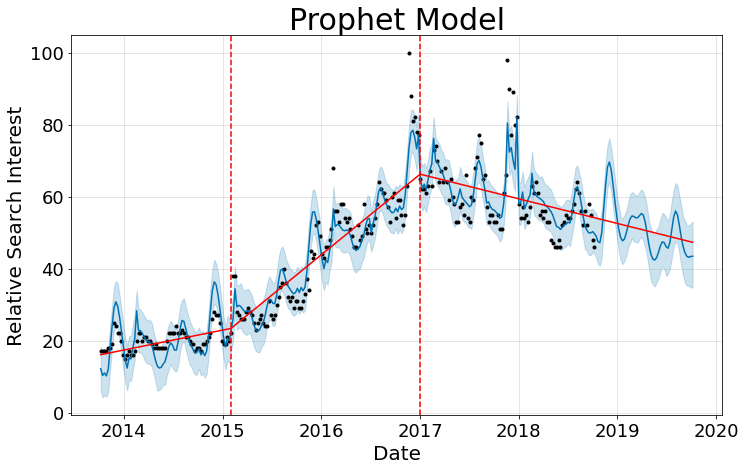

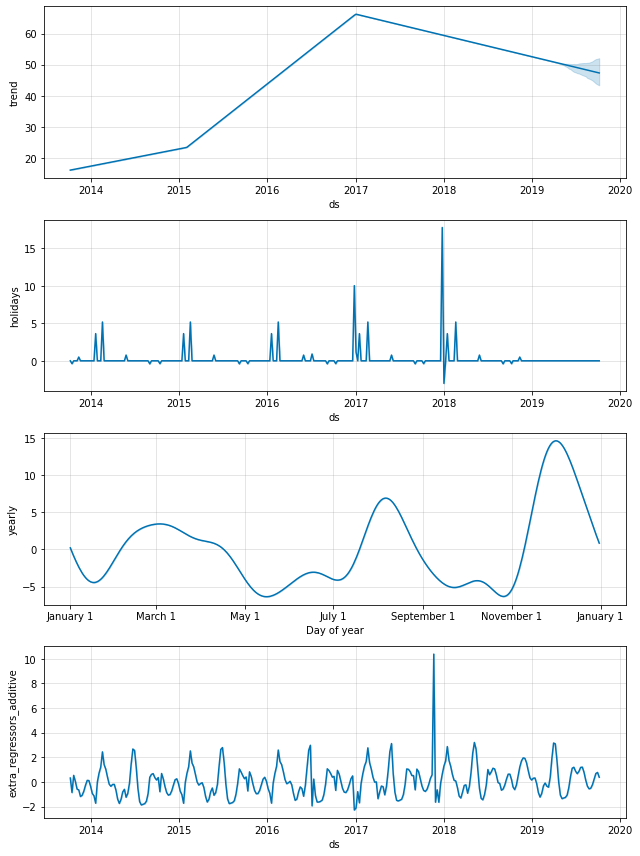

In [95]:
# Same model we used with manual changepoints and the added regressor of Adspend
changepoints = ['2015-02-01', '2017-01-01']
m = Prophet(changepoints=changepoints)
m.add_country_holidays(country_name='US')
m.add_regressor('Adspend')
m.fit(prophetdata2)

future = m.make_future_dataframe(periods=52, freq='W')
future['Adspend'] = future_adspend['yhat']
forecast = m.predict(future)

fig1 = m.plot(forecast, xlabel='Date', ylabel='Relative Search Interest')
ax1 = fig1.gca()
ax1.set_title("Prophet Model", size=30)
ax1.set_xlabel("Date", size=20)
ax1.set_ylabel("Relative Search Interest", size=20)
ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

fig2 = m.plot_components(forecast)

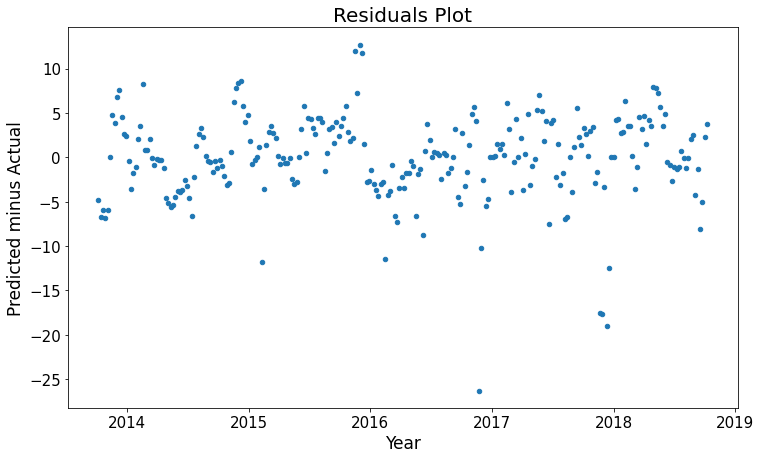

In [96]:
residuals = pd.DataFrame()
residuals['y'] = forecast['yhat'][0:262] - prophetdata2['y']
residuals['x'] = prophetdata2['ds']

plot = residuals.plot(x='x', 
               y='y',
               kind='scatter',
               figsize = (12,7),
               legend = False,
               fontsize = 15)


plot.axes.set_title('Residuals Plot', fontsize=20)
plot.axes.set_xlabel('Year', fontsize=17)
plot.axes.set_ylabel('Predicted minus Actual', fontsize=17);

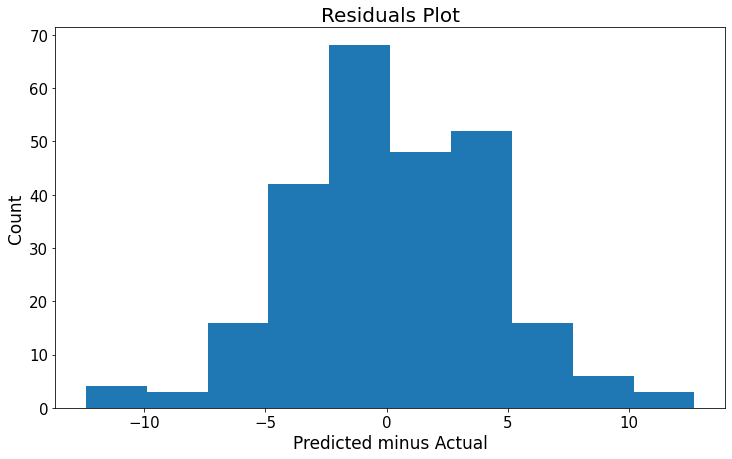

In [97]:
residuals2 = residuals[residuals['y'] > -15]

plot = residuals2.plot(x='x', 
               y='y',
               kind='hist',
               figsize = (12,7),
               legend = False,
               fontsize = 15)


plot.axes.set_title('Residuals Plot', fontsize=20)
plot.axes.set_ylabel('Count', fontsize=17)
plot.axes.set_xlabel('Predicted minus Actual', fontsize=17);

# And now, SARIMAX

In [98]:
mergedweeklydata.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL,ADIDAS: (United States),TOTALdiff,valuediff
FIXED TIME,,,,,,,,,,,,,,
2013-10-07,665.6,0.0,10.1,77.9,0,0.0,27.2,0.0,0.0,0,780.8,17,NaN,NaN
2013-10-14,792.6,0.0,10.1,0.0,0,222.0,5.6,0.0,0.0,0,1030.3,17,249.5,0.0
2013-10-21,594.2,0.0,10.1,0.0,0,300.0,9.3,0.0,0.0,0,913.6,17,-116.7,0.0
2013-10-28,1366.4,715.0,11.5,0.0,0,195.0,4.6,10.8,0.9,0,2304.2,17,1390.6,0.0
2013-11-04,835.1,0.0,13.5,0.0,0,126.0,8.2,0.0,0.0,0,982.8,18,-1321.4,1.0


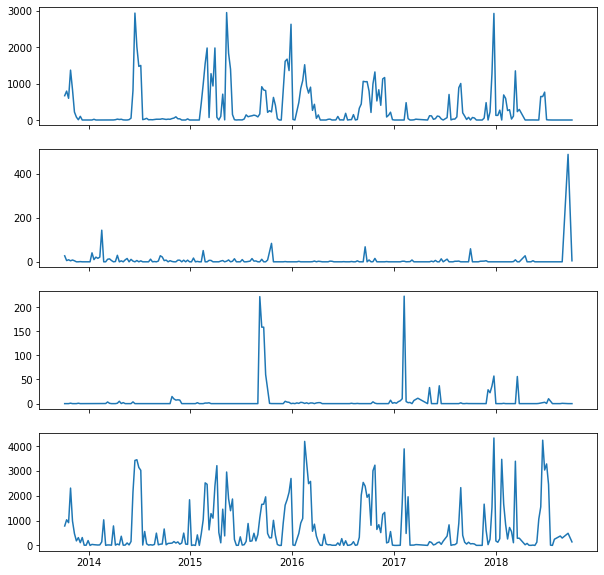

In [99]:
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex='all') # have the one x axis printed for all 4 graphs instead of for each graph

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV']) #Spot cable is one of two basic ways to buy advertising on cable television. It allows regional small-business owners to show their TV ads on national cable networks that air in their local markets without having to buy airtime from those networks.
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])

# Granger-Causality Tests

In [100]:
mergedweeklydata.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL,ADIDAS: (United States),TOTALdiff,valuediff
FIXED TIME,,,,,,,,,,,,,,
2013-10-07,665.6,0.0,10.1,77.9,0,0.0,27.2,0.0,0.0,0,780.8,17,NaN,NaN
2013-10-14,792.6,0.0,10.1,0.0,0,222.0,5.6,0.0,0.0,0,1030.3,17,249.5,0.0
2013-10-21,594.2,0.0,10.1,0.0,0,300.0,9.3,0.0,0.0,0,913.6,17,-116.7,0.0
2013-10-28,1366.4,715.0,11.5,0.0,0,195.0,4.6,10.8,0.9,0,2304.2,17,1390.6,0.0
2013-11-04,835.1,0.0,13.5,0.0,0,126.0,8.2,0.0,0.0,0,982.8,18,-1321.4,1.0


In [101]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
data = sm.datasets.macrodata.load_pandas()
data = mergedweeklydata[["ADIDAS: (United States)", "TOTAL"]].pct_change().dropna()

In [102]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
data = sm.datasets.macrodata.load_pandas()
data = data.data[["realgdp", "realcons"]].pct_change().dropna()

In [103]:

mergedweeklydata['ADIDAS: (United States)'].round(decimals = 0)




#df['DataFrame column'].round(decimals = number of decimal places needed)


FIXED TIME
2013-10-07    17
2013-10-14    17
2013-10-21    17
2013-10-28    17
2013-11-04    18
              ..
2018-07-30    62
2018-08-20    56
2018-08-27    52
2018-09-17    58
2018-10-01    48
Name: ADIDAS: (United States), Length: 249, dtype: int64

In [104]:
#granger causality
from statsmodels.tsa.stattools import grangercausalitytests

#perform Granger-Causality test
grangercausalitytests(mergedweeklydata[["ADIDAS: (United States)", 'TOTAL']], maxlag=[7])



TypeError: ignored

In [ ]:
#reverse Granger-Causality test
grangercausalitytests(mergedweeklydata[['TOTAL',"ADIDAS: (United States)"]], maxlag=[7])



# Above and Beyond - Dua Lipa Search Data


In [159]:
from time import sleep
import csv

import pandas as pd
import numpy as np

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as pyplot

In [122]:
#Going Above and beyond - analyzing Dua Lipa's (newly sponsored) Google search trends
dua_gtrends = pd.read_csv('drive/MyDrive/dua.csv', parse_dates=['Week'])
dua_gtrends['Week'] = dua_gtrends['Week'] + pd.Timedelta(1, unit='D') # Add a day to align with the adspend information.
dua_gtrends.set_index('Week', inplace = True)
dua_gtrends.index.names = ['period']
dua_gtrends.head(3)

,Dua Lipa: (United States)
period,
2018-07-02,43.0
2018-01-15,48.0
2018-01-22,50.0


In [180]:
#reduce weekly
mergedweeklydata_dua = mergedweeklydata.join(dua_gtrends)

# Drop first 208 rows
# by selecting all rows from 209th row onwards
N = 217
df = mergedweeklydata_dua.iloc[N: , :]


In [181]:
df.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL,ADIDAS: (United States),TOTALdiff,valuediff,Dua Lipa: (United States)
2018-01-08,126.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,126.5,54,-53.4,-4.0,42.0
2018-01-15,270.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,270.5,57,144.0,3.0,48.0
2018-01-22,0.0,0.0,0.0,0.0,0,3460.2,0.0,0.0,0.0,0,3460.2,54,3189.7,-3.0,50.0
2018-01-29,686.8,0.0,0.0,0.0,0,831.2,0.0,147.5,0.6,0,1666.2,55,-1794.0,1.0,48.0
2018-02-05,592.6,0.0,0.0,0.0,0,245.4,0.0,0.0,0.0,0,838.0,53,-828.2,-2.0,NaN


In [164]:
#let's get a sense of what the variation in the data is.
#standard deviation is 16.65. Varies from 20 to 100.
print(df['Dua Lipa: (United States)'].describe())

count     24.000000
mean      42.125000
std       16.645439
min       20.000000
25%       33.500000
50%       39.000000
75%       48.000000
max      100.000000
Name: Dua Lipa: (United States), dtype: float64


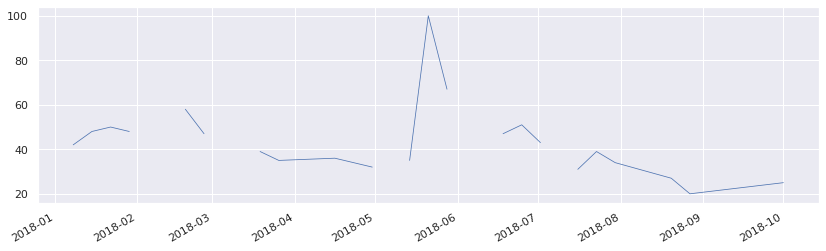

In [165]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 4)})
df['Dua Lipa: (United States)'].plot(linewidth=0.75)

In [155]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [166]:
adf_test(df['Dua Lipa: (United States)'])

Results of Dickey-Fuller Test:


MissingDataError: ignored

In [151]:
# difference the data to remove stationarity
df['trends_diff_1'] = df['Dua Lipa: (United States)'].diff(1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,TOTAL,ADIDAS: (United States),TOTALdiff,valuediff,Dua Lipa: (United States),trends_diff_1
2018-01-01,126.5,0.0,0.0,0.0,0,0.0,0.0,53.4,0.0,0,179.9,58,-4136.8,-24.0,NaN,NaN
2018-01-08,126.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,126.5,54,-53.4,-4.0,42.0,NaN
2018-01-15,270.5,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,270.5,57,144.0,3.0,48.0,6.0
2018-01-22,0.0,0.0,0.0,0.0,0,3460.2,0.0,0.0,0.0,0,3460.2,54,3189.7,-3.0,50.0,2.0
2018-01-29,686.8,0.0,0.0,0.0,0,831.2,0.0,147.5,0.6,0,1666.2,55,-1794.0,1.0,48.0,-2.0


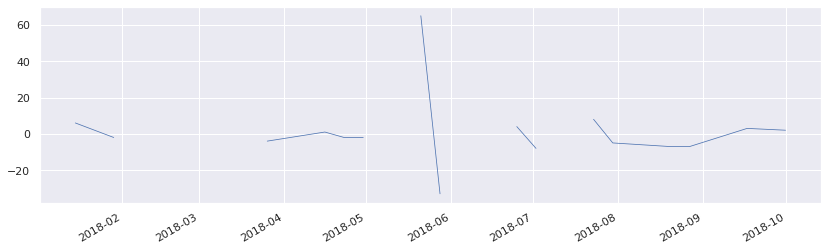

In [152]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(14, 4)})
df['trends_diff_1'].plot(linewidth=0.75)

In [168]:
plot_acf(df['trends_diff_1'][1:], lags=12)b

SyntaxError: ignored

In [176]:
#auto arima
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 32.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [178]:
from pmdarima.arima import auto_arima


In [187]:
#drop last row from dua data
df_droplastrow = df[:-1]

df = df.dropna()

In [188]:
#univariate

stepwise_fit = auto_arima(df['Dua Lipa: (United States)'], start_p=0, start_q=0,
                             max_p=2, max_q=0, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

ValueError: ignored